In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import utils


import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

In [10]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(DEVICE, torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device("cpu")
    print(DEVICE)

cpu


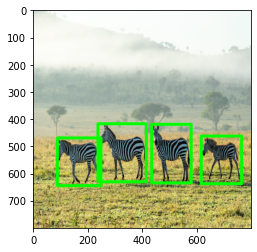

In [42]:
# load image and annotations
IMG = utils.img_read('./Reference/zebras.jpg')
bbox0 = np.array([[223, 782, 623, 1074], [597, 695, 1038, 1050],
                  [1088, 699, 1452, 1057], [1544, 771, 1914, 1063]])
labels = np.array([1, 1, 1, 1]) # 0: background, 1: zebra
img0 = np.copy(IMG)

# resizing img
img_800 = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
# get ratio
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioList = [Wratio, Hratio, Wratio, Hratio]
bbox = []
## Update boxes in proportions
for box in bbox0:
    box = [int(a*b) for a, b in zip(box, ratioList)]
    bbox.append(box)
bbox = np.array(bbox)
## imgshow
img = utils.show_bboxes(img_800 , bbox)
plt.imshow(img)
plt.show()

In [43]:
# get model
model = torchvision.models.vgg16(pretrained=True).to(DEVICE)
features = list(model.features)
print('VGG layer 개수 :', len(features))
dummy_img = torch.zeros((1 , 3, 800, 800)).float() #get dummy_img

##dummy train
output = dummy_img.clone().to(DEVICE)
print('input_image shape :' , output.shape)
reg_features = []
for feature in features:
    output = feature(output)
    if output.size()[2] < 800 // 16:
        break
    reg_features.append(feature)
    out_channels = output.size()[1]

print('reg_features 개수 :' ,len(reg_features))
print('output_chennel size :' , out_channels)

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG layer 개수 : 31
input_image shape : torch.Size([1, 3, 800, 800])
reg_features 개수 : 30
output_chennel size : 512


In [44]:
#get extractor
faster_rcnn_feature_extractor = nn.Sequential(*reg_features)

transform = transforms.Compose([transforms.ToTensor()]) ## make transformer
imgTensor = transform(img).to(DEVICE) ## tensor to cpu
imgTensor = imgTensor.unsqueeze(0) ##expand dims
output_map = faster_rcnn_feature_extractor(imgTensor) ## VGG output_features

print(output_map.size())

torch.Size([1, 512, 50, 50])


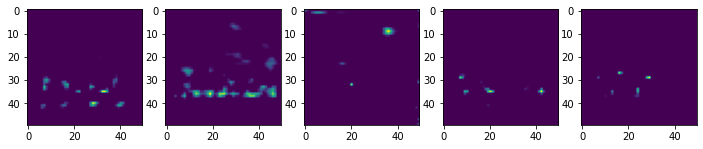

In [45]:
feature_map = output_map.data.cpu().numpy().squeeze(0) ## output shape (1512 , 50 , 50)
fig = plt.figure(figsize = ( 12, 4 ))
figNo = 1
for i in range(5):
    fig.add_subplot(1 , 5 , figNo)
    plt.imshow(feature_map[i])
    figNo += 1
plt.show()

## Generate Anchors

In [46]:
# sub_sampling ratio = 1 / 16
# sub_sample feature map size : 50
# anchor box 50 * 50 * 9 = 22500
# get Anchor box center

feature_size = 800 // 16
ctr_x  = np.arange(16 , (feature_size + 1)* 16 , 16) # 16 부터 step 16으로 51 * 16 미만까지 반복 즉 50개 생성
print(ctr_x)

[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [49]:
# coordinates of the 2500 center points to generate anchor boxes

idx = 0
ctr = np.zeros((2500, 2))
for i in range(len(ctr_x)):
    for j in range(len(ctr_x)):
        ctr[idx, 1] = ctr_x[i] - 8
        ctr[idx, 0] = ctr_x[j] - 8
        idx += 1

print(ctr.shape) # [x, y] * 2500

(2500, 2)


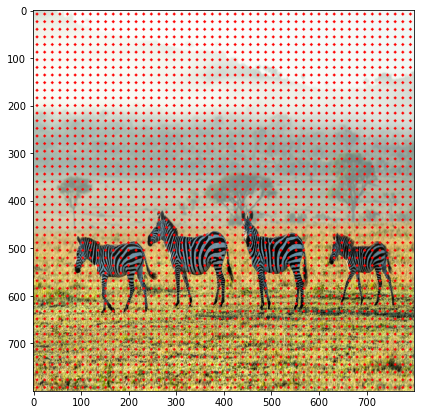

In [48]:
# display the 2500 anchors within image
img_clone2 = np.copy(img_800)
ctr_int = ctr.astype("int32")

plt.figure(figsize=(7, 7))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone2, (ctr_int[i][0], ctr_int[i][1]),
              radius=1, color=(255, 0, 0), thickness=3)
plt.imshow(img_clone2)
plt.show()

In [53]:
ratio = [0.5 , 1 , 2]
scales = [8 , 16 , 32]
sub_sample = 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9 ) , 4)) ## (2500 * 9 , 4)
print(anchor_boxes.shape , ' -> 22500 * [xmin , ymin , xmax , ymax]')

(22500, 4)  -> 22500 * [xmin , ymin , xmax , ymax]


In [58]:
idx = 0
for c in ctr:
    ctr_y , ctr_x = c
    for i in range(len(ratio)):
        for j in range(len(scales)):

            h = sub_sample * scales[j] * np.sqrt(ratio[i])
            w = sub_sample * scales[j] * np.sqrt(1. / ratio[i])

            # anchor box [x1, y1, x2, y2]
            anchor_boxes[idx, 1] = ctr_y - h / 2.
            anchor_boxes[idx, 0] = ctr_x - w / 2.
            anchor_boxes[idx, 3] = ctr_y + h / 2.
            anchor_boxes[idx, 2] = ctr_x + w / 2.
            idx += 1
print(h , w)
print(anchor_boxes.shape)

724.0773439350247 362.03867196751236
(22500, 4)


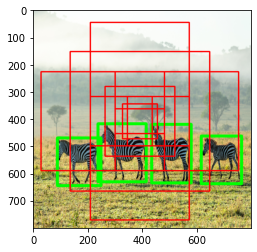

In [60]:
# display the anchor boxes of one anchor and the ground truth boxes

img_clone = np.copy(img)

# draw random anchor boxes
for i in range(11025, 11034):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])

    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)

plt.imshow(img_clone)
plt.show()

In [ ]:
# draw all anchor boxes

# add paddings(can't draw anchor boxes out of image boundary)
img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3,400,400,400,400,cv2.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(anchor_boxes)):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])

    cv2.rectangle(img_clone5, (x1+400, y1+400), (x2+400, y2+400), color=(255, 0, 0),
                 thickness=3)

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

In [62]:
# ignore the cross-boundary anchor boxes
# valid anchor boxes with (x1, y1) > 0 and (x2, y2) <= 800

index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800))[0]

print(index_inside.shape)

# only 8940 anchor boxes are inside the boundary out of 22500
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


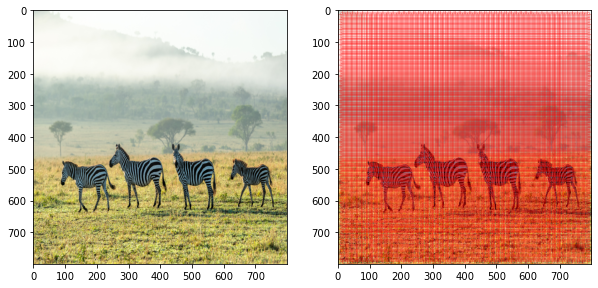

In [67]:
img_clone = img_800.copy()
img_clone_bbox = img_800.copy()
for i in range(len(valid_anchor_boxes)):
    x1 = int(valid_anchor_boxes[i][0])
    y1 = int(valid_anchor_boxes[i][1])
    x2 = int(valid_anchor_boxes[i][2])
    y2 = int(valid_anchor_boxes[i][3])
    cv2.rectangle(img_clone_bbox, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=1)
plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img_clone)
plt.subplot(122), plt.imshow(img_clone_bbox)
plt.show()